# COMP9517 Group Project

### Data Exploration & Analysis & Cleanup

Please run this file FIRST.

Please run all the cells in this file first and follow the instructions in this file. This notebook's purpose is to perform preliminary dataset exploration and perform any dataset cleanup. Finally, it will save the processed dataset as a dataloader in /models as dataset.pth.

### Data Exploration & Analysis

First we will do some preliminary data exploration to understand what is contained in this dataset. Since this is a novel dataset, there is no guarantee that the data is complete, or that every single photo contains at least one head, carapace, and fin. 

In [1]:
from pycocotools.coco import COCO

# Load in annotations file
annotation_file = 'turtles-data/data/annotations.json'
coco = COCO(annotation_file)
print("\n----------------- Dataset Information -----------------\n")

# Count number of images for our dataset
image_ids = coco.getImgIds()
num_images = len(image_ids)
print("Number of images in dataset: ", num_images)

# Identify the number of categories in our dataset
coco.loadCats(coco.getCatIds())
category_ids = coco.loadCats(coco.getCatIds())
categories = {category['id']: category['name'] for category in category_ids}

# Ensure there are no additonal categories that we did not expect
expected_categories = {'turtle', 'head', 'flipper'}
if set(categories.values()) != expected_categories:
    raise ValueError(f"Unexpected categories in dataset {categories}")
else:
    print("\nAll categories are expected in dataset")

loading annotations into memory...
Done (t=3.78s)
creating index...
index created!

----------------- Dataset Information -----------------

Number of images in dataset:  8729

All categories are expected in dataset


In [ ]:
cat_ids = coco.getCatIds()
categories = coco.loadCats(cat_ids)

# Important: Note how each category has a specific ID such as 1, 2, 3. These are NOT changeable!
for category in categories:
    print(f"ID: {category['id']}, Name: {category['name']}")

ID: 1, Name: turtle
ID: 2, Name: flipper
ID: 3, Name: head


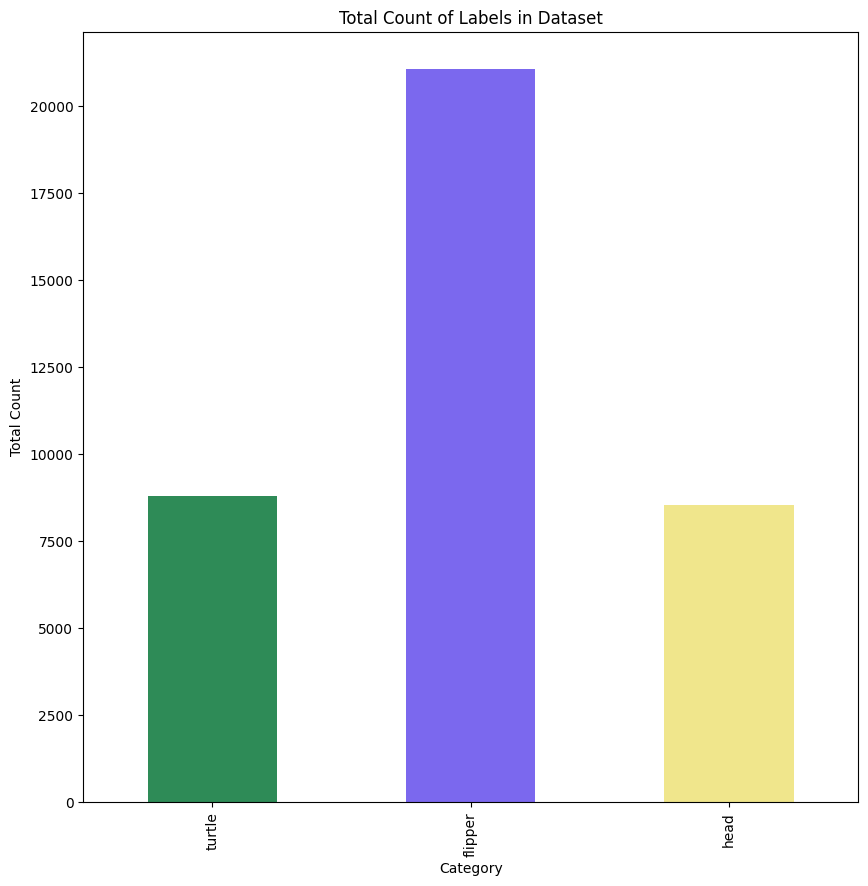

c:\Users\Sun\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Sun\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Sun\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Sun\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is de

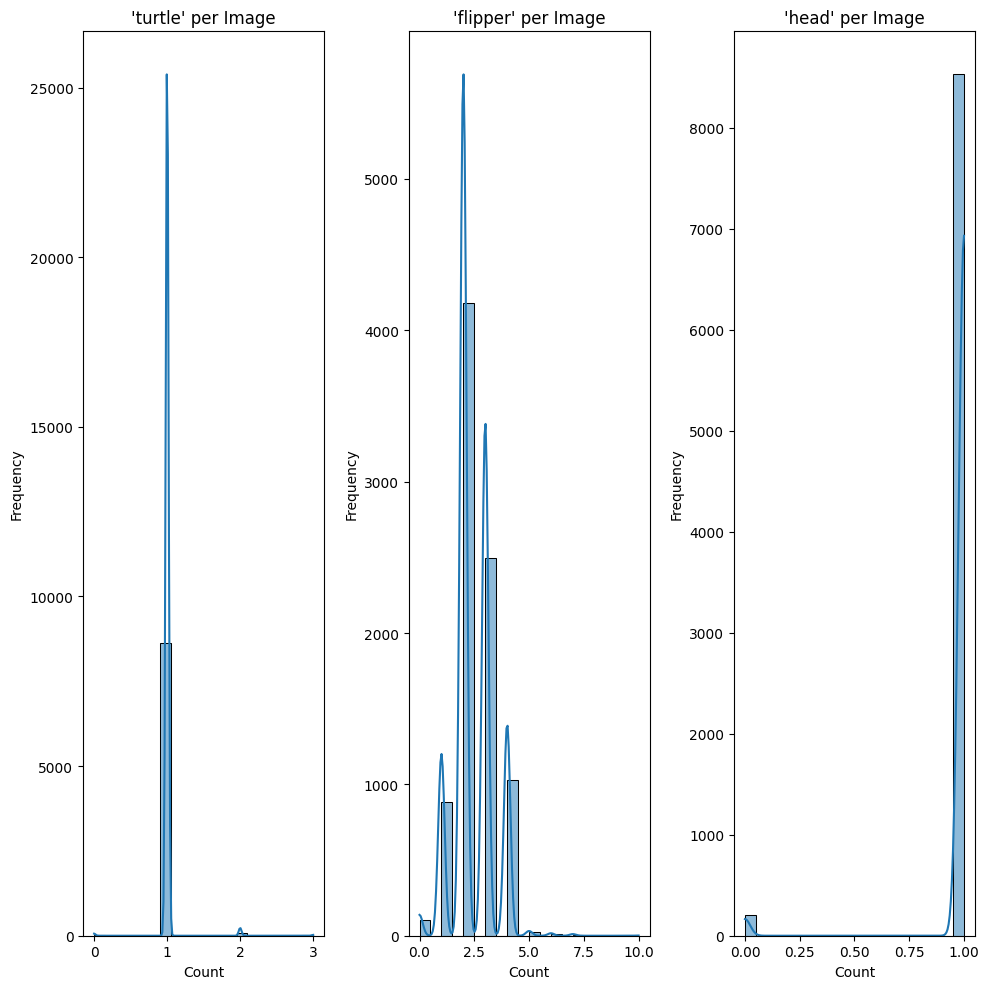

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


category_names = ["turtle", "flipper", "head"]  # Mistake found ! Make sure to maintain order as seen above ^^
cat_ids = coco.getCatIds(catNms=category_names)

# Create a dictionary to count how many counts of each category there are in each image repr imageid
category_counts = {'image_id': [], 'turtle': [], 'flipper': [], 'head': []}

# Loop over each image
img_ids = coco.getImgIds()
for img_id in img_ids:
    ann_ids = coco.getAnnIds(imgIds=img_id, catIds=cat_ids)
    anns = coco.loadAnns(ann_ids)

    # Append the current image ID
    category_counts["image_id"].append(img_id)

    # Count number of each category for current image ID.
    category_counts["turtle"].append(
        sum(ann["category_id"] == cat_ids[0] for ann in anns)
    )
    category_counts["flipper"].append(
        sum(ann["category_id"] == cat_ids[1] for ann in anns)
    )
    category_counts["head"].append(
        sum(ann["category_id"] == cat_ids[2] for ann in anns)
    )

# End result is a dictionary with the key as iumage_id. The values are the number of each category in that image.
# ie: {image_id: [turtle_count, flipper_count, head_count]}

# Convert to dataframe
category_counts_df = pd.DataFrame(category_counts)
category_sums = category_counts_df[["turtle", "flipper", "head"]].sum()

# Totals for each category
plt.figure(figsize=(10, 10))
category_sums.plot(kind="bar", color=["seagreen", "mediumslateblue", "khaki"])
plt.title("Total Count of Labels in Dataset")
plt.xlabel("Category")
plt.ylabel("Total Count")
plt.show()

plt.figure(figsize=(10, 10))
for i, category in enumerate(["turtle", "flipper", "head"]):
    plt.subplot(1, 3, i + 1)
    sns.histplot(category_counts_df[category], kde=True, bins=20)
    plt.title(f"'{category}' per Image")
    plt.xlabel("Count")
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

Dataset contains 8729 images. Note above in the second graph (distribution of categories per class). Some images may not contain a turtle, head, or flipper so we will investigate these files manually. 

In [6]:
required_categories = ["turtle", "flipper", "head"]
cat_ids = coco.getCatIds(catNms=required_categories)
cat_ids_map = dict(zip(category_names, cat_ids))

missing_labels_images = {category: 0 for category in required_categories}
img_ids = coco.getImgIds()

for img_id in img_ids:
    missing_categories = []
    for category, cat_id in cat_ids_map.items():
        ann_ids = coco.getAnnIds(imgIds=img_id, catIds=cat_id)
        if not ann_ids:
            missing_categories.append(category)

    for category in missing_categories:
        missing_labels_images[category] += 1

# Report results
for category, count in missing_labels_images.items():
    print(f"Number of images missing '{category}' label: {count}\n")

Number of images missing 'turtle' label: 20

Number of images missing 'flipper' label: 101

Number of images missing 'head' label: 203



We are interested in particular about the absence of the turtle label in the dataset, as these could be considered poorly labelled datasets. As a result we will take a closer examination of these files, and purge them if we think they will negatively impact our training and testing results.

In [7]:
# Load in the ones without a turtle to investigate what is going on with the missing labels

missing_turtle_img_ids = []
for img_id in img_ids:
    ann_ids = coco.getAnnIds(imgIds=img_id, catIds=cat_ids_map["turtle"])
    if not ann_ids:
        missing_turtle_img_ids.append(img_id)

In [13]:
import numpy as np
from PIL import Image

def load_images(missing_part_images_ids):
    for image_id in missing_part_images_ids:

        # Debug missing images
        try:
            img = coco.loadImgs(image_id)[0]
        except TypeError:
            print(f"[DEBUG]: This image ID is missing: {image_id}")
            continue

        try:
            # Otherwise plot it out. SInce we know theres only 20 iamges we can plot them all out.
            image = np.array(Image.open(f"turtles-data/data/{img['file_name']}"))
            plt.figure(figsize=(20, 10))

            # Original
            plt.subplot(1, 3, 1)
            plt.imshow(image)
            plt.axis("off")
            plt.title("Original Image")

            # Annotations
            plt.subplot(1, 3, 2)
            plt.imshow(image)
            cat_ids = coco.getCatIds()
            ann_ids = coco.getAnnIds(imgIds=img["id"], catIds=cat_ids, iscrowd=None)
            anns = coco.loadAnns(ann_ids)
            coco.showAnns(anns)
            plt.axis("off")
            plt.title("Annotations")

            # Masked
            plt.subplot(1, 3, 3)
            mask = np.zeros((img["height"], img["width"]), dtype=np.uint8)
            for ann in anns:
                mask += coco.annToMask(ann)
            plt.imshow(mask, cmap="plasma")
            plt.axis("off")
            plt.title("Masked")
            plt.tight_layout()
            plt.show()
        except FileNotFoundError:
            print(f"[DEBUG]: This image was already deleted: {image_id}. You have already cleaned up the dataset so it is missing.")

*Note to the Marker*: The following code will plot 20 images of the dataset with their annotations.

In [ ]:
""" 
# NOTE! Unload these cells before pushing to git to avoid making the file too large.
# Clear the output of the cells above before pushing to git.

# NOTE! Additional note to the marker: It will take time to load all the images.
"""

load_images(missing_turtle_img_ids)

Based on the images above, the dataset quality is quite concerning. We will do the same for the other datasets which are missing labels with the exact same method as above.

In [15]:
# Load in files again in case of lost or incorrect reference
# annotation_file = "turtles-data/data/annotations.json"
# coco = COCO(annotation_file)
image_ids = coco.getImgIds()

missing_head_image_ids = []
missing_flipper_image_ids = []

for img_id in image_ids:
    ann_ids = coco.getAnnIds(imgIds=img_id, catIds=cat_ids_map["head"])
    if not ann_ids:
        missing_head_image_ids.append(img_id)

    ann_ids = coco.getAnnIds(imgIds=img_id, catIds=cat_ids_map["flipper"])
    if not ann_ids:
        missing_flipper_image_ids.append(img_id)

print(f"Number of images missing 'head' label: {len(missing_head_image_ids)}")
print(f"Number of images missing 'flipper' label: {len(missing_flipper_image_ids)}")

Number of images missing 'head' label: 203
Number of images missing 'flipper' label: 101


In [ ]:
""" 
# NOTE! Unload these cells before pushing to git to avoid making the file too large.
# Clear the output of the cells above before pushing to git.
# Since there are 304 images missing the head label, this is extra important!

# NOTE! Additional note to the marker: It will take time to load all the images. It is
# recommended to run the code and kill it after a few images have been loaded to see the output.
"""

load_images(missing_head_image_ids)
load_images(missing_flipper_image_ids)

### Dataset Cleanup & Re-validation

Here we will directly edit and delete the unnecessary files of the COCO dataset. Based on the analysis done in the section above, we will only delete the 20 images that are labelled with no turtle as every single datapoint there have quite significant errors in their annotation.

In [17]:
# We will need to re-fetch all references to the COCO objects as well as the imageIDs of the errornous dataset
# images... Please make sure you run this on your own machine prior to training the model.

import json
import os
from pycocotools.coco import COCO

# Load in annotations file
annotation_file = "turtles-data/data/annotations.json"
coco = COCO(annotation_file)
print("\n----------------- Before Cleanup -----------------\n")

# Count number of images for our dataset
image_ids = coco.getImgIds()
num_images = len(image_ids)
print("Number of images in dataset: ", num_images) # 8729 -> 8709

# Identify the number of categories in our dataset
category_ids = coco.loadCats(coco.getCatIds())
categories = {category["id"]: category["name"] for category in category_ids}

# Find the ones that are missing the turtle label
missing_turtle_img_ids = []
for img_id in image_ids:
    ann_ids = coco.getAnnIds(imgIds=img_id, catIds=cat_ids_map["turtle"])
    if not ann_ids:
        missing_turtle_img_ids.append(img_id)
print(f"Number of images missing 'turtle' label: {len(missing_turtle_img_ids)}")

print(f"\nRemoving these images from the dataset...\n")

# Begin the purge. This will actually remove the images from the dataset so if you run this cell, some cells above WILL break.
with open(annotation_file, 'r') as f:
    coco_data = json.load(f)

# Remove images and annotations from JSON
coco_data['images'] = [img for img in coco_data['images'] if img['id'] not in missing_turtle_img_ids]
coco_data['annotations'] = [ann for ann in coco_data['annotations'] if ann['image_id'] not in missing_turtle_img_ids]

# Save as a new updated JSON file
with open("turtles-data/data/updated_annotations.json", 'w') as f:
    json.dump(coco_data, f)
print("\n----------------- After Cleanup -----------------\n")
print("Updated annotations saved to 'turtles-data/data/updated_annotations.json'. Please use this from now on!")

# Delete image files
images_path = "turtles-data/data/"
for img_id in missing_turtle_img_ids:
    img_info = coco.loadImgs([img_id])[0]
    img_file_path = os.path.join(images_path, img_info['file_name'])
    if os.path.exists(img_file_path):
        os.remove(img_file_path)
        print(f"[SUCCESS]: Deleted image file: {img_file_path}")
    else:
        print(f"[ERROR!]: Image file not found: {img_file_path}")

print("All files without turtles have been deleted successfully!")

# Load in new annotations as validation
annotation_file = "turtles-data/data/updated_annotations.json"
coco = COCO(annotation_file)
image_ids = coco.getImgIds()
num_images = len(image_ids)
print("Number of images in dataset: ", num_images)

# Find the ones that are missing the turtle label
missing_turtle_img_ids = []
for img_id in image_ids:
    ann_ids = coco.getAnnIds(imgIds=img_id, catIds=cat_ids_map["turtle"])
    if not ann_ids:
        missing_turtle_img_ids.append(img_id)
print(f"Number of images missing 'turtle' label: {len(missing_turtle_img_ids)}")

loading annotations into memory...
Done (t=3.46s)
creating index...
index created!

----------------- Before Cleanup -----------------

Number of images in dataset:  8729
Number of images missing 'turtle' label: 20

Removing these images from the dataset...


----------------- After Cleanup -----------------

Updated annotations saved to 'turtles-data/data/updated_annotations.json'. Please use this from now on!
[ERROR!]: Image file not found: turtles-data/data/images/t099/YRcDEhpcgy.JPG
[ERROR!]: Image file not found: turtles-data/data/images/t102/wFLjWpiUvj.jpeg
[ERROR!]: Image file not found: turtles-data/data/images/t221/LDRANGMdHp.JPG
[ERROR!]: Image file not found: turtles-data/data/images/t221/wXxaQqJIQN.JPG
[ERROR!]: Image file not found: turtles-data/data/images/t231/BqCROAbeaX.jpg
[ERROR!]: Image file not found: turtles-data/data/images/t243/UHJWFhnlIg.JPG
[ERROR!]: Image file not found: turtles-data/data/images/t322/SUlvTiCoSI.JPG
[ERROR!]: Image file not found: turtles-data/

Please note: Use updated_annotations.json from this point onwards, annotations.json will not be correct!

Another issue we did not yet take into consideration is the size of each image, for image segmentation task we should normalise all pictures to a single size. If there are any issues, we will need to fix them as well as their segmentation masks, but we will first check if there is a need for this.

In [18]:
import os
from PIL import Image
from collections import defaultdict


def check_image_sizes(folder_path):
    size_counts = defaultdict(int)
    total_images = 0

    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(
                (".png", ".jpg", ".jpeg")
            ):
                img_path = os.path.join(root, file)
                with Image.open(img_path) as img:
                    img_size = img.size

                    # Save this image size to the approrpiate resolution key
                    size_counts[img_size] += 1
                    total_images += 1

    # Print the results
    print(f"\n----------------- Image Size Verification -----------------\n")
    print(f"Total images checked: {total_images}")
    if len(size_counts) == 1:
        print("All images have the same size:", list(size_counts.keys())[0])
    else:
        print("Image size counts:")
        for size, count in size_counts.items():
            print(f"Size {size}: {count} images")

check_image_sizes("turtles-data/data/images")


----------------- Image Size Verification -----------------

Total images checked: 8709
Image size counts:
Size (2000, 1124): 64 images
Size (2000, 1333): 7814 images
Size (1124, 2000): 1 images
Size (2000, 1120): 1 images
Size (2000, 1500): 512 images
Size (2000, 1544): 1 images
Size (1500, 2000): 3 images
Size (1674, 1320): 1 images
Size (2000, 1221): 1 images
Size (1333, 2000): 108 images
Size (2000, 1650): 1 images
Size (2000, 1379): 1 images
Size (2000, 1217): 2 images
Size (2000, 1179): 1 images
Size (2000, 1570): 1 images
Size (1819, 1361): 1 images
Size (1883, 1428): 1 images
Size (2000, 1671): 2 images
Size (1933, 965): 1 images
Size (1707, 1053): 1 images
Size (2000, 1233): 1 images
Size (2000, 1145): 1 images
Size (2000, 1115): 1 images
Size (2000, 1397): 1 images
Size (2000, 1325): 1 images
Size (2000, 1218): 1 images
Size (2000, 1203): 1 images
Size (2000, 1335): 1 images
Size (2000, 1580): 1 images
Size (1533, 1112): 1 images
Size (2000, 1111): 1 images
Size (2000, 1252)

Unfortunately, it is clear that this dataset has not been processed in any way by the original publisher and we will need to process it ourselves. Luckily, we can use albumentations, a powerful community built library to transform data in instance segmentation for both images as well as their segmentation spatial transformations. We will reshape all images to a default size of 512 x 512. This size was chosen very specifically because of the significant computational advantages, including reduced memory consumption, faster training cycles, and efficient batch handling on standard hardware. 

However, resizing comes with its trade-offs. It results in a loss of fine-grained details which could impact the model’s accuracy of smaller objects and detailed boundaries such as the edges of flippers. Despite this, the standardised 512x512 resolution was chosen as a compromise between computational efficiency and feature preservation.

In [4]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

resize_transform = A.Compose(
    [
        A.Resize(512, 512, p=1),                                             # Resize to 512 x 512
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalises pixel values
        ToTensorV2(),                                                        # Converts to PyTorch tensor
    ],
    bbox_params=A.BboxParams(format="coco", label_fields=["category_ids"]),
)

In [5]:
from torch.utils.data import Dataset
import torch
from PIL import Image
import numpy as np
import os
from pycocotools.coco import COCO


class SeaTurtleDataset(Dataset):
    def __init__(self, root, annotation, transforms=None, target_size=(512, 512)):
        self.root = root
        self.coco = COCO(annotation)
        self.transforms = transforms
        self.cat_ids = self.coco.getCatIds()
        self.img_ids = list(self.coco.imgs.keys())
        self.target_size = target_size

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, idx):
        # Image params
        img_id = self.img_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.root, img_info["file_name"])
        img = Image.open(img_path).convert("RGB")

        # Annotations
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)

        # BBox and category IDs
        bbox = [ann["bbox"] for ann in anns]
        category_ids = [ann["category_id"] for ann in anns]

        # Apply transformations
        original_size = img.size
        image = np.array(img)

        # Masks from annotations
        masks = self._getmask(self.img_ids[idx], image)

        if self.transforms and original_size != self.target_size:
            transformed = self.transforms(
                image=image, bboxes=bbox, masks=[masks], category_ids=category_ids
            )
            image = transformed["image"]        # Resize image
            bbox = transformed["bboxes"]        # Resize bounding boxes
            masks = transformed["masks"][0]     # Resize masks
            category_ids = transformed["category_ids"]
        else:
            image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)
            masks = torch.tensor(masks, dtype=torch.uint8)

        # Convert bounding boxes and category IDs to tensors
        bboxes = torch.tensor(bbox, dtype=torch.float32)
        category_ids = torch.tensor(category_ids, dtype=torch.int64)

        return {
            "image": image,
            "bboxes": bboxes,
            "masks": masks,
            "category_ids": category_ids,
            "original_size": original_size,
            "target_size": self.target_size,
        }

    def _getmask(self, image_id, image):
        categories = {"turtle": 1, "flipper": 2, "head": 3}
        # Initialise the mask
        mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)

        # Process each category
        for category_name, category_id in categories.items():
            ann_ids = self.coco.getAnnIds(
                imgIds=image_id, catIds=category_id, iscrowd=None
            )
            annotations = self.coco.loadAnns(ann_ids)

            # Create a temporary mask for the current category
            temp_mask = np.zeros_like(mask)

            for ann in annotations:
                temp_mask += self.coco.annToMask(ann)
            # Assign category-specific value to the final mask
            if category_name == "turtle":
                mask[temp_mask > 0] = 1
            elif category_name == "flipper":
                mask[temp_mask > 0] = 2
            elif category_name == "head":
                mask[temp_mask > 0] = 3

        return mask

In [6]:
# Test the resized images to verify the transformation works and the masks are still correct.

import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from pycocotools.coco import COCO
from pycocotools import mask as mask_utils


# Finds all images that are not the correct size and saves the imageIDs as a list for correction
def get_wrong_size_image_ids(folder_path, coco, target_size=(512, 512)):
    wrong_image_ids = []
    for img_id in coco.getImgIds():
        img_info = coco.loadImgs(img_id)[0]
        img_path = os.path.join(folder_path, img_info["file_name"])

        if not os.path.exists(img_path):
            print(f"[Error]: Image file not found: {img_path}")
            continue

        with Image.open(img_path) as img:
            if img.size != target_size: 
                wrong_image_ids.append(img_id)

    return wrong_image_ids


# Loads images with their updated sizes and displays their masks to ensure they are transformed correctly
def load_images_with_resize(missing_part_images_ids, dataset, coco):
    for image_id in missing_part_images_ids:
        # Load original image
        img_info = coco.loadImgs(image_id)[0]
        image_path = os.path.join(dataset.root, img_info["file_name"])
        original_image = np.array(Image.open(image_path).convert("RGB"))

        plt.figure(figsize=(20, 10))

        # Display original image
        plt.subplot(1, 3, 1)
        plt.imshow(original_image)
        plt.axis("off")
        plt.title(
            f"Original Image - {original_image.shape[1]}x{original_image.shape[0]}"
        )

        # Find the image we want
        sample = dataset[dataset.img_ids.index(image_id)]
        transformed_image = (sample["image"].permute(1, 2, 0).cpu().numpy())
        transformed_mask = (sample["masks"].cpu().numpy()) 
        new_height, new_width = transformed_image.shape[:2]

        # Resized
        plt.subplot(1, 3, 2)
        plt.imshow(transformed_image)
        plt.axis("off")
        plt.title(f"Resized Image - {new_height}x{new_height}")

        # Resized with mask
        plt.subplot(1, 3, 3)
        plt.imshow(transformed_image)
        plt.imshow(transformed_mask, cmap="gist_ncar", alpha=1.0, interpolation="nearest")
        plt.axis("off")
        plt.title("Resized Image with Mask Overlay")

        plt.tight_layout()
        plt.show()


# Reinitalise all COCO objects and image IDs for processing
annotation_file = "turtles-data/data/updated_annotations.json"
coco = COCO(annotation_file)
dataset = SeaTurtleDataset(
    root="turtles-data/data",
    annotation="turtles-data/data/updated_annotations.json",
    transforms=resize_transform,
)
wrong_size_image_ids = get_wrong_size_image_ids("turtles-data/data", coco)

print(f"----------------- Wrong Size Image IDs -----------------\n")

print(f"Number of images with wrong size: {len(wrong_size_image_ids)}")
print(f"Note: These images will be differently colored in the display but that is just normalisation from albumentations.\n")

print(f"Now processing the images to be displayed . . . Please run the next cell to see the images and their transformations.\n")

loading annotations into memory...
Done (t=3.34s)
creating index...
index created!
loading annotations into memory...
Done (t=3.61s)
creating index...
index created!
----------------- Wrong Size Image IDs -----------------

Number of images with wrong size: 8709
Note: These images will be differently colored in the display but that is just normalisation from albumentations.

Now processing the images to be displayed . . . Please run the next cell to see the images and their transformations.



In [ ]:
# ----------------- Displaying the images ------------------
# As always, make sure to unload these cells before pushing
# to git to avoid making the file too large.
# Clear the output of the cells above before pushing to git.
#
# NOTE: TO MARKER: It is not recommended to let this cell 
# run to completion as it will take a very long time. This
# is just a visualisation of the transformations being ok.
# ----------------------------------------------------------

load_images_with_resize(wrong_size_image_ids, dataset, coco)

### Data Loader

For reusability across all teammembers and the tutor who needs to run all cells in the notebook, we will use a seed so the result will always be the same no matter who or what or where or when or why or how this notebook is run.

In [9]:
import numpy as np
import random
import torch

def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

set_seed(42)

In [ ]:
from torch.utils.data import random_split, DataLoader

cleaned_dataset = SeaTurtleDataset(
    root="turtles-data/data/images",
    annotation="turtles-data/data/updated_annotations.json",
    transforms=resize_transform,
)

# We will choose a 80-20 split for training and testing.
# We will then choose a 80-20 split for training and validation.
# Total: 64% training, 16% validation, 20% testing
train_and_val_size = int(0.8 * len(cleaned_dataset))
test_size = len(cleaned_dataset) - train_and_val_size
train_size = int(0.8 * train_and_val_size)
val_size = train_and_val_size - train_size

print(f"----------------- Dataset Split -----------------\n")
print(f"Training size: {train_size}")
print(f"Validation size: {val_size}\n")
print(f"Test size: {test_size}\n")

train_and_val_set, test_set = random_split(cleaned_dataset, [train_size + val_size, test_size])
train_set, val_set = random_split(train_and_val_set, [train_size, val_size])

models_dir = "./models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

torch.save({"train": train_set, "val": val_set, "test": test_set}, "./models/dataset.pth")

print(f"----------------- Dataset Saved -----------------\n")
print("Dataset saved to '../models/dataset.pth'")
print("Congratulations! You have successsfully saved the processed dataset split.")
print("Now you can load this dataset in the next notebook for training.")
print("You may now proceed to the next notebook for training.")

loading annotations into memory...
Done (t=4.04s)
creating index...
index created!
----------------- Dataset Split -----------------

Training size: 5573
Validation size: 1394

Test size: 1742

----------------- Dataset Saved -----------------

Dataset saved to '../models/dataset.pth'
Congratulations! You have successsfully saved the processed dataset split.
Now you can load this dataset in the next notebook for training.
You may now proceed to the next notebook for training.
